# **Image Classification with ConvNeXt**

Written By: Tharnarch Thoranisttakul

This project is for the internship program in Japan at Kanazawa University.

The topic is as stated above. Firstly, we will take a look at classifying image with ConvNeXt. Then, we will take a look at classifying image with Transformers (if we have time then we will take a look at Transformers).

Right now, we will only focus on **ConvNeXt**.

## **Data Exploration**

The task from this lab was to use **CIFAR-100** as the dataset for image classification

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from tqdm.notebook import tqdm
from PIL import Image
import json
import glob
import os

%matplotlib inline

# Import scikit-learn libraries and packages
from sklearn.preprocessing import LabelEncoder

# Import PyTorch libraries and packages
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
import torchvision
from torchvision import transforms

from torchvision.models import resnet50, ConvNeXt, ConvNeXt_Base_Weights
from torchvision.ops import StochasticDepth

# For Importing models from HuggingFace
from transformers import AutoModelForImageClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\omzlette\miniconda3\envs\dl-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\omzlette\miniconda3\envs\dl-env\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\omzlette\miniconda3\envs\dl-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Extract dataset
# Uncomment the code below to extract the dataset
# !tar xvzf data/cifar-100-python.tar.gz -C data

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# Load the data
train = unpickle('data/cifar-100-python/train')
test = unpickle('data/cifar-100-python/test')

In [5]:
print(f'Train Keys: {train.keys()}\nTest Keys: {test.keys()}')
print('-'*20)
print(f'Train Data Shape: {train[b"data"].shape}\nTest Data Shape: {test[b"data"].shape}')
print('-'*20)
print(f'Train Data Type: {type(train[b"data"])}\nTest Data Type: {type(test[b"data"])}')

Train Keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
Test Keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
--------------------
Train Data Shape: (50000, 3072)
Test Data Shape: (10000, 3072)
--------------------
Train Data Type: <class 'numpy.ndarray'>
Test Data Type: <class 'numpy.ndarray'>


### **Dataset Description**

From the [official website](https://www.cs.toronto.edu/~kriz/cifar.html), the CIFAR-100 dataset contains 100 classes. Each class contains 600 images each, 500 of which are training images and the rest are testing images.

Similarly to CIFAR-10, the data shape is a 60000x3072 numpy array. This corresponds to the code and description above, which is 500 training images and 100 testing images in each class, resulting in a grand total of 50000x3072 and 10000x3072 numpy array.

In [6]:
print(f'Train Coarse Labels: {train[b"coarse_labels"]}\nTest Coarse Labels: {test[b"coarse_labels"]}')
print('-'*20)
print(f'Train Fine Labels: {train[b"fine_labels"]}\nTest Fine Labels: {test[b"fine_labels"]}')
print('-'*20)
print(f'Train Batch Label: {train[b"batch_label"]}\nTest Batch Label: {test[b"batch_label"]}')

Train Coarse Labels: [11, 15, 4, 14, 1, 5, 18, 3, 10, 11, 5, 17, 2, 9, 10, 5, 18, 8, 16, 10, 16, 17, 2, 5, 17, 6, 12, 17, 8, 12, 18, 9, 17, 16, 11, 5, 19, 14, 7, 6, 15, 13, 10, 8, 17, 9, 14, 18, 19, 15, 1, 7, 5, 3, 10, 7, 17, 6, 14, 17, 16, 0, 0, 8, 4, 14, 4, 10, 15, 4, 2, 16, 11, 19, 16, 7, 19, 14, 10, 8, 5, 12, 12, 11, 10, 8, 12, 13, 10, 7, 14, 11, 14, 19, 0, 4, 12, 13, 1, 15, 0, 5, 0, 8, 3, 15, 4, 19, 17, 6, 17, 12, 6, 0, 14, 10, 9, 11, 6, 10, 12, 1, 14, 4, 8, 1, 2, 12, 4, 12, 18, 17, 5, 0, 6, 0, 12, 11, 9, 5, 17, 2, 14, 12, 5, 0, 13, 12, 16, 4, 13, 0, 18, 15, 10, 15, 5, 13, 1, 14, 12, 3, 19, 1, 2, 15, 5, 2, 3, 12, 16, 0, 11, 12, 2, 0, 4, 15, 7, 9, 11, 14, 11, 3, 13, 13, 19, 13, 14, 8, 14, 1, 16, 9, 16, 18, 19, 6, 5, 19, 5, 1, 14, 14, 10, 12, 8, 7, 10, 9, 16, 19, 9, 13, 16, 11, 13, 9, 5, 18, 3, 2, 5, 5, 11, 2, 5, 3, 14, 19, 18, 18, 13, 12, 19, 11, 13, 5, 15, 5, 18, 6, 14, 11, 3, 17, 2, 16, 5, 5, 8, 18, 18, 4, 14, 10, 10, 19, 17, 14, 14, 0, 8, 5, 12, 12, 7, 14, 12, 17, 4, 1, 15, 14, 

The fine labels are classes, while the coarse labels are superclasses stated below.

|**Superclass No.**|**Superclass**|**Classes**|
|:-:|:-:|:-:|
|1|aquatic mammals|beaver, dolphin, otter, seal, whale|
|2|fish|aquarium fish, flatfish, ray, shark, trout|
|3|flowers|orchids, poppies, roses, sunflowers, tulips|
|4|food containers|bottles, bowls, cans, cups, plates|
|5|fruit and vegetables|apples, mushrooms, oranges, pears, sweet peppers|
|6|household electrical devices|clock, computer keyboard, lamp, telephone, television|
|7|household furniture|bed, chair, couch, table, wardrobe|
|8|insects|bee, beetle, butterfly, caterpillar, cockroach|
|9|large carnivores|bear, leopard, lion, tiger, wolf|
|10|large man-made outdoor things|bridge, castle, house, road, skyscraper|
|11|large natural outdoor scenes|cloud, forest, mountain, plain, sea|
|12|large omnivores and herbivores|camel, cattle, chimpanzee, elephant, kangaroo|
|13|medium-sized mammals|fox, porcupine, possum, raccoon, skunk|
|14|non-insect invertebrates|crab, lobster, snail, spider, worm|
|15|people|baby, boy, girl, man, woman|
|16|reptiles|crocodile, dinosaur, lizard, snake, turtle|
|17|small mammals|hamster, mouse, rabbit, shrew, squirrel|
|18|trees|maple, oak, palm, pine, willow|
|19|vehicles 1|bicycle, bus, motorcycle, pickup truck, train|
|20|vehicles 2|lawn-mower, rocket, streetcar, tank, tractor|

The labels are kept in the meta file. Therefore, we will extract the label names (fine and coarse) from the meta file directly.

In [7]:
# Load the labels
label = unpickle('data/cifar-100-python/meta')
print(f'Label Keys: {label.keys()}')
print('-'*20)
print(f'Label Fine Label Names: {label[b"fine_label_names"]}')
print('-'*20)
print(f'Label Coarse Label Names: {label[b"coarse_label_names"]}')

label_fine = label[b"fine_label_names"]
label_coarse = label[b"coarse_label_names"]

# Decode labels
label_fine = [x.decode('utf-8') for x in label_fine]
label_coarse = [x.decode('utf-8') for x in label_coarse]

label2id = {label_fine[i]: i for i in range(len(label_fine))}
id2label = {i: label_fine[i] for i in range(len(label_fine))}

Label Keys: dict_keys([b'fine_label_names', b'coarse_label_names'])
--------------------
Label Fine Label Names: [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider

In [8]:
train_data = train[b"data"]
train_coarse_labels = train[b"coarse_labels"]
train_fine_labels = train[b"fine_labels"]
train_batch_label = train[b"batch_label"]

test_data = test[b"data"]
test_coarse_labels = test[b"coarse_labels"]
test_fine_labels = test[b"fine_labels"]
test_batch_label = test[b"batch_label"]

In [9]:
train_data[0], train_coarse_labels[0], train_fine_labels[0], train_batch_label, test_data[0], test_coarse_labels[0], test_fine_labels[0], test_batch_label

(array([255, 255, 255, ...,  10,  59,  79], dtype=uint8),
 11,
 19,
 b'training batch 1 of 1',
 array([199, 196, 195, ..., 215, 211, 183], dtype=uint8),
 10,
 49,
 b'testing batch 1 of 1')

In [10]:
print(f'Train data min: {train_data.min()}\nTrain data max: {train_data.max()}')
print(f'Test data min: {test_data.min()}\nTest data max: {test_data.max()}')
print('-'*20)
print(f'Train data mean: {train_data.mean()}\nTrain data std: {train_data.std()}')
print(f'Test data mean: {test_data.mean()}\nTest data std: {test_data.std()}')

Train data min: 0
Train data max: 255
Test data min: 0
Test data max: 255
--------------------


Train data mean: 121.936059453125
Train data std: 68.38895658894971
Test data mean: 122.24118916015625
Test data std: 68.63056877656638


## **Data Preprocessing**

Since the image data's range is (0, 255), we will normalize it to (0, 1).

In [11]:
# Reshape the data
train_data = train_data.reshape(50000, 32, 32, 3)
test_data = test_data.reshape(10000, 32, 32, 3)

print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


In [12]:
def plot_images(data, datalabel, fulllabel):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[i])
        plt.xlabel(fulllabel[datalabel[i]])

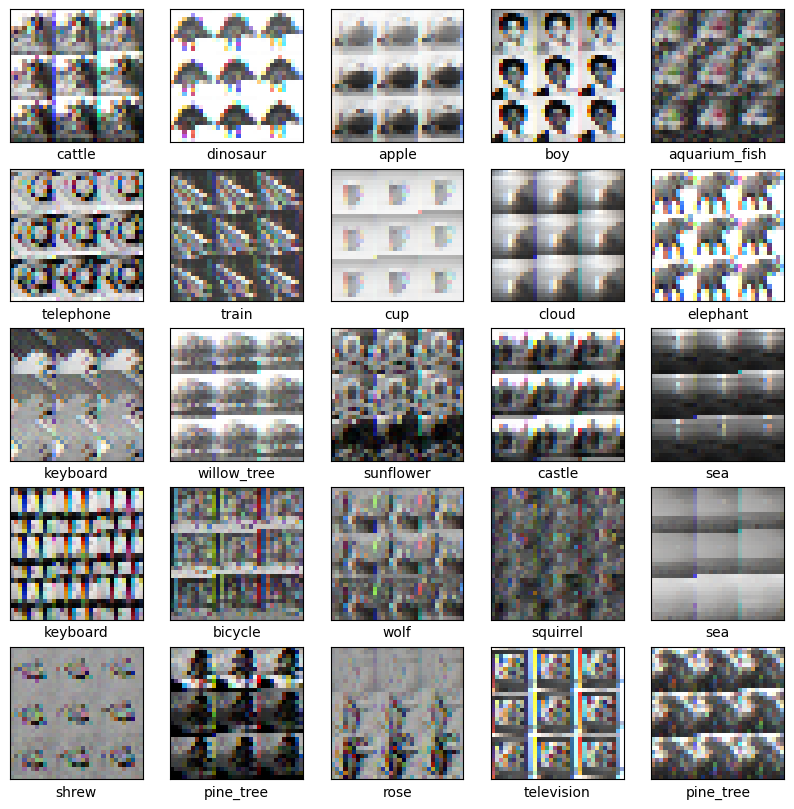

In [13]:
plot_images(train_data, train_fine_labels, label_fine)

Seems like we reshaped the data wrongly. We will try to reshape it again by separating each color profile (R, G, B) and restack them.

In [14]:
train_data = train[b'data']
test_data = test[b'data']

train_data_R = train_data[:, :1024].reshape(50000, 32, 32)
train_data_G = train_data[:, 1024:2048].reshape(50000, 32, 32)
train_data_B = train_data[:, 2048:].reshape(50000, 32, 32)

test_data_R = test_data[:, :1024].reshape(10000, 32, 32)
test_data_G = test_data[:, 1024:2048].reshape(10000, 32, 32)
test_data_B = test_data[:, 2048:].reshape(10000, 32, 32)

# Stack the data
train_data = np.stack((train_data_R, train_data_G, train_data_B), axis=3)
test_data = np.stack((test_data_R, test_data_G, test_data_B), axis=3)

print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


In [15]:
# Convert the data to float
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# Normalize the data
train_data /= 255.0
test_data /= 255.0

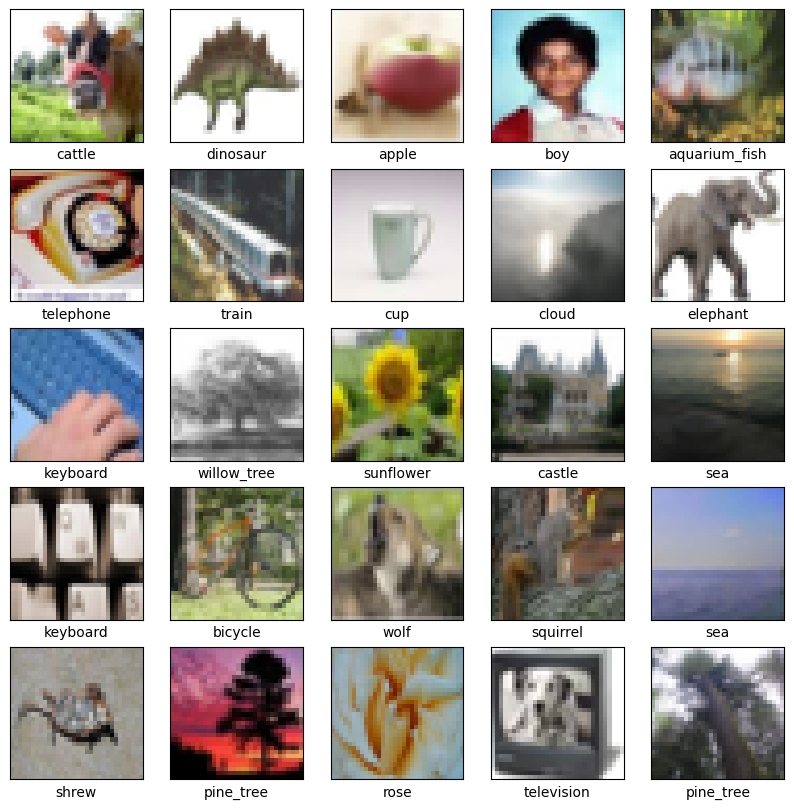

In [16]:
plot_images(train_data, train_fine_labels, label_fine)

In [17]:
print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


The reason why we have to separate them like this instead of directly reshaping them is because the data were flatten before saving as text file.

Credit to: https://www.kaggle.com/code/yipengzhou3/cifar100-pytorch for doing the same 'wrong' approach to reshaping the data.

In [18]:
X_train, y_train = train_data, train_fine_labels
X_test, y_test = test_data, test_fine_labels

num_classes = 100
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [19]:
# Find mean and std
mean = X_train.mean(axis=(0, 1, 2), keepdims=True)
std = X_train.std(axis=(0, 1, 2), keepdims=True)

mean = tuple(mean.flatten())
std = tuple(std.flatten())

print(f'Mean: {mean}\nStd: {std}')

Mean: (0.32768, 0.32768, 0.32768)
Std: (0.30221897, 0.2838716, 0.27933034)


In [20]:
#Transform data to Tensor
transform_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [21]:
# Apply the augmentation
noaugment_train_data = []
noaugment_train_label = []
for image, label in zip(X_train, y_train_encoded):
    noaugment_train_data.append(transform_data(image))
    noaugment_train_label.append(label)

noaugment_test_data = []
noaugment_test_label = []
for image, label in zip(X_test, y_test_encoded):
    noaugment_test_data.append(transform_data(image))
    noaugment_test_label.append(label)

noaugment_train_data = torch.stack(noaugment_train_data)
noaugment_test_data = torch.stack(noaugment_test_data)

# Change data from double to float
noaugment_train_data = noaugment_train_data.type(torch.FloatTensor)
noaugment_test_data = noaugment_test_data.type(torch.FloatTensor)

print(f'(No) Augmented Train Data Shape: {noaugment_train_data.shape}\n(No) Augmented Test Data Shape: {noaugment_test_data.shape}')

(No) Augmented Train Data Shape: torch.Size([50000, 3, 32, 32])
(No) Augmented Test Data Shape: torch.Size([10000, 3, 32, 32])


Choosing Batch Size: https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU

In [22]:
# Create the dataset
train_dataset = TensorDataset(noaugment_train_data, torch.Tensor(noaugment_train_label))
test_dataset = TensorDataset(noaugment_test_data, torch.Tensor(noaugment_test_label))

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
# EarlyStopping (https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py)
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='models/earlystop/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if not os.path.exists('models/earlystop/'):
            os.makedirs('models/earlystop/')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [24]:
from transformers.modeling_outputs import ImageClassifierOutputWithNoAttention
# Training
def train_model(models, modelnames, criterion, optimizer, scheduler, num_epochs, train_loader, test_loader, patience=3, path_to_folder='models/earlystop'):

    # Store the loss and accuracy
    traintestData = {}

    for model, modelname in zip(models, modelnames):
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []

        # Early stopping
        early_stopping = EarlyStopping(patience=patience, path=f'{path_to_folder}/{modelname}.pt')

        for param in model.parameters():
            param.requires_grad_()

        for epoch in range(num_epochs):

            ### Train the model ###

            model.train()
            running_loss = 0.0
            train_correct = 0
            train_samples = 0
            for _, batch in enumerate(train_loader):
                images = batch[0].to(device)
                labels = batch[1].to(device).long()

                optimizer.zero_grad()
                
                outputs = model(images)

                # Convert outputs to tensor
                if isinstance(outputs, ImageClassifierOutputWithNoAttention):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

                # Training Accuracy
                _, predicted = torch.max(outputs, dim=1)
                train_correct += (predicted == labels).sum().item()
                train_samples += labels.size(0)

            train_epoch_loss = running_loss/len(train_loader.dataset)
            train_epoch_acc = train_correct/train_samples

            if scheduler is not None:
                scheduler.step()

            ### Test the model ###

            model.eval()
            with torch.no_grad():
                total_loss = 0
                test_correct = 0
                test_total = 0
                for _, batch in enumerate(test_loader):
                    images = batch[0].to(device)
                    labels = batch[1].to(device).long()

                    outputs = model(images)

                    if isinstance(outputs, ImageClassifierOutputWithNoAttention):
                        outputs = outputs.logits

                    # Test Loss
                    loss = criterion(outputs, labels)
                    total_loss += loss.item() * images.size(0)

                    # Test Accuracy
                    _, predicted = torch.max(outputs, dim=1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                
                test_epoch_loss = total_loss/len(test_loader.dataset)
                test_epoch_acc = test_correct/test_total

            # Save the loss and accuracy for train and test set
            train_loss.append(train_epoch_loss)
            train_acc.append(train_epoch_acc)
            test_loss.append(test_epoch_loss)
            test_acc.append(test_epoch_acc)

            print(f'''ConvNeXt {modelname} -> Epoch: {epoch+1}/{num_epochs} 
            Train Loss: {train_epoch_loss} | Train Accuracy: {train_epoch_acc} 
            Test Loss: {test_epoch_loss} | Test Accuracy: {test_epoch_acc}''')

            # Early Stopping
            early_stopping(test_epoch_loss, model)

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        traintestData[f'Training Loss_{modelname}'] = train_loss
        traintestData[f'Training Accuracy_{modelname}'] = train_acc
        traintestData[f'Test Loss_{modelname}'] = test_loss
        traintestData[f'Test Accuracy_{modelname}'] = test_acc

    return traintestData

In [25]:
def lossAccPlot(lossAccDict, modelnames):
    names = ['Loss', 'Accuracy']

    num_models = len(modelnames)
    num_plots = len(names)

    _, axes = plt.subplots(num_models, num_plots, figsize=(20, 5*num_models))

    # If there is only one row or one column of subplots, convert axes to a 2-dimensional array
    if num_models == 1 or num_plots == 1:
        axes = axes.reshape(num_models, num_plots)

    for idx, modelname in enumerate(modelnames):
        for i, name in enumerate(names):
            val_train = lossAccDict[f'Training Loss_{modelname}'] if name == 'Loss' else lossAccDict[f'Training Accuracy_{modelname}']
            axes[idx, i].plot(val_train, label='Training')

            val_test = lossAccDict[f'Test Loss_{modelname}'] if name == 'Loss' else lossAccDict[f'Test Accuracy_{modelname}']
            axes[idx, i].plot(val_test, label='Testing')

            axes[idx, i].set_xlabel('Epoch')
            axes[idx, i].set_ylabel(name)
            axes[idx, i].legend()

In [26]:
def printTestAcc(testAccDict, modelnames):
    # Get last and max test accuracy
    for modelname in modelnames:
        print(f'ConvNeXt {modelname} -> Last Test Accuracy: {testAccDict[f"Test Accuracy_{modelname}"][-1]} | Max Test Accuracy: {max(testAccDict[f"Test Accuracy_{modelname}"])} (Epoch:{testAccDict[f"Test Accuracy_{modelname}"].index(max(testAccDict[f"Test Accuracy_{modelname}"]))})')

## **ConvNeXt**

In [ ]:
convnext_tiny = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_tiny_wd = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_base_wd = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_tiny.to(device)
convnext_tiny_wd.to(device)
convnext_base.to(device)
convnext_base_wd.to(device)

models = [convnext_tiny, convnext_base]
modelnames = ['Tiny', 'Base']
models_wd = [convnext_tiny_wd, convnext_base_wd]
modelnames_wd = ['TinyWD', 'BaseWD']

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this mo

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW([{'params': model.parameters()} for model in models], lr=5e-5)
optimizer_wd = torch.optim.AdamW([{'params': model.parameters()} for model in models_wd], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
noWDDict = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt Tiny -> Epoch: 1/30 
            Train Loss: 2.4809817026519774 | Train Accuracy: 0.4219 
            Test Loss: 1.479985366821289 | Test Accuracy: 0.5912
ConvNeXt Tiny -> Epoch: 2/30 
            Train Loss: 1.1193327165031433 | Train Accuracy: 0.68584 
            Test Loss: 1.1722746953964234 | Test Accuracy: 0.661
ConvNeXt Tiny -> Epoch: 3/30 
            Train Loss: 0.6793769610118866 | Train Accuracy: 0.80488 
            Test Loss: 1.0951946096420289 | Test Accuracy: 0.6836
ConvNeXt Tiny -> Epoch: 4/30 
            Train Loss: 0.38800684960365295 | Train Accuracy: 0.8927 
            Test Loss: 1.1232445398330688 | Test Accuracy: 0.688
EarlyStopping counter: 1 out of 3
ConvNeXt Tiny -> Epoch: 5/30 
            Train Loss: 0.19918426948070525 | Train Accuracy: 0.95198 
            Test Loss: 1.181402639579773 | Test Accuracy: 0.688
EarlyStopping counter: 2 out of 3
ConvNeXt Tiny -> Epoch: 6/30 
            Train Loss: 0.09584185667991638 | Train Accuracy: 0.98116 
      

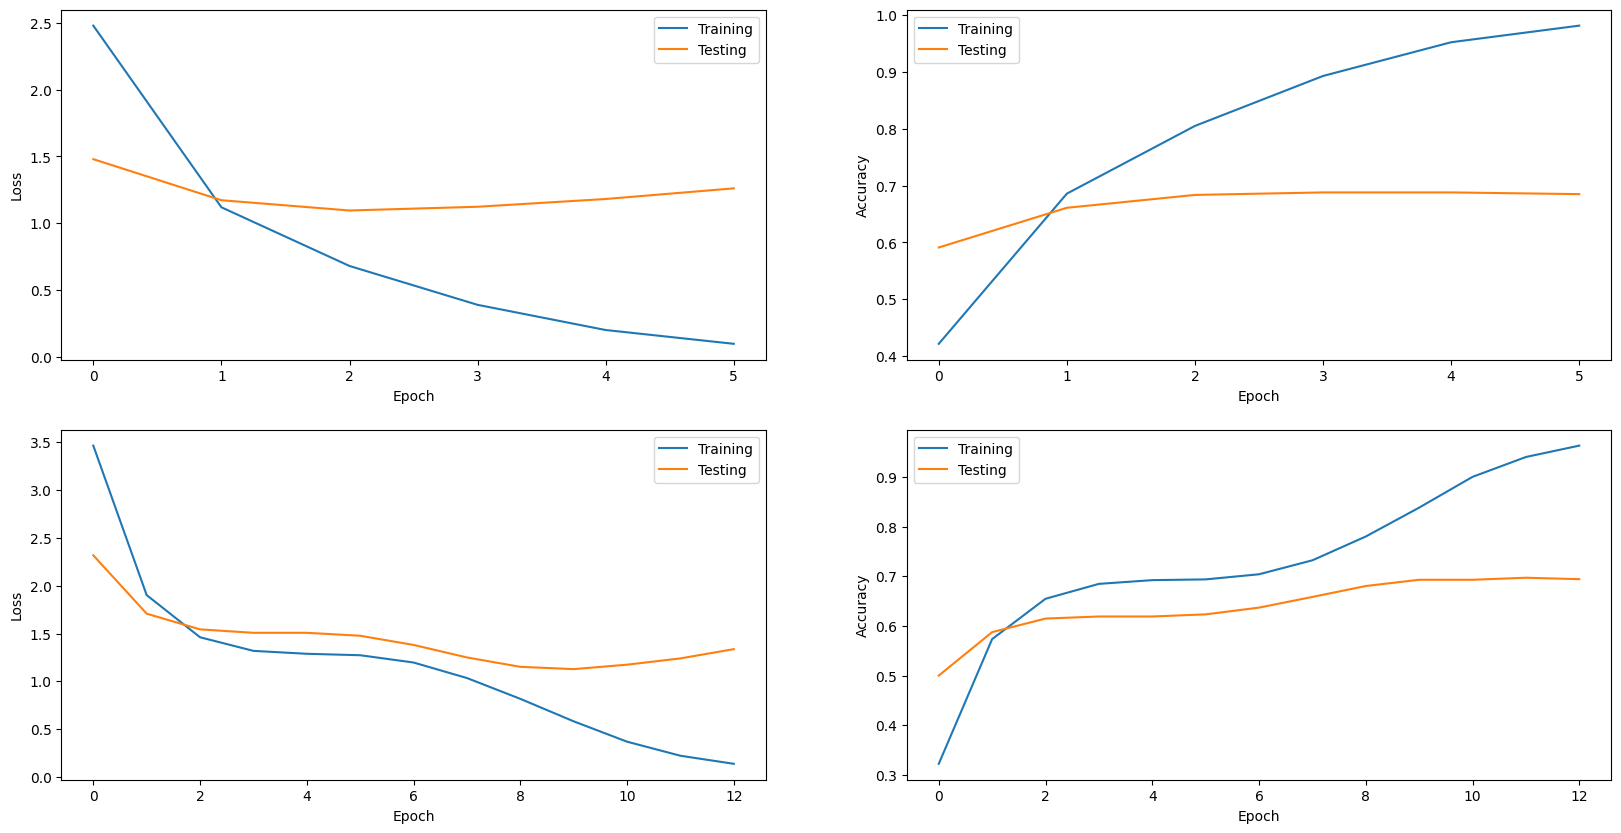

In [ ]:
lossAccPlot(noWDDict, modelnames)

In [ ]:
WDDict = train_model(models_wd, modelnames_wd, criterion, optimizer_wd, lr_scheduler, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt TinyWD -> Epoch: 1/30 
            Train Loss: 2.4554281044387816 | Train Accuracy: 0.42936 
            Test Loss: 1.4640570880889892 | Test Accuracy: 0.6031
ConvNeXt TinyWD -> Epoch: 2/30 
            Train Loss: 1.1081903325843812 | Train Accuracy: 0.68972 
            Test Loss: 1.1530679294586181 | Test Accuracy: 0.6663
ConvNeXt TinyWD -> Epoch: 3/30 
            Train Loss: 0.6654472223758697 | Train Accuracy: 0.80884 
            Test Loss: 1.0905396110534669 | Test Accuracy: 0.6812
ConvNeXt TinyWD -> Epoch: 4/30 
            Train Loss: 0.37024301360130313 | Train Accuracy: 0.89642 
            Test Loss: 1.1425100472450256 | Test Accuracy: 0.6846
EarlyStopping counter: 1 out of 3
ConvNeXt TinyWD -> Epoch: 5/30 
            Train Loss: 0.1821232057571411 | Train Accuracy: 0.95394 
            Test Loss: 1.2433393616676331 | Test Accuracy: 0.6813
EarlyStopping counter: 2 out of 3
ConvNeXt TinyWD -> Epoch: 6/30 
            Train Loss: 0.08775060847461223 | Train Accurac

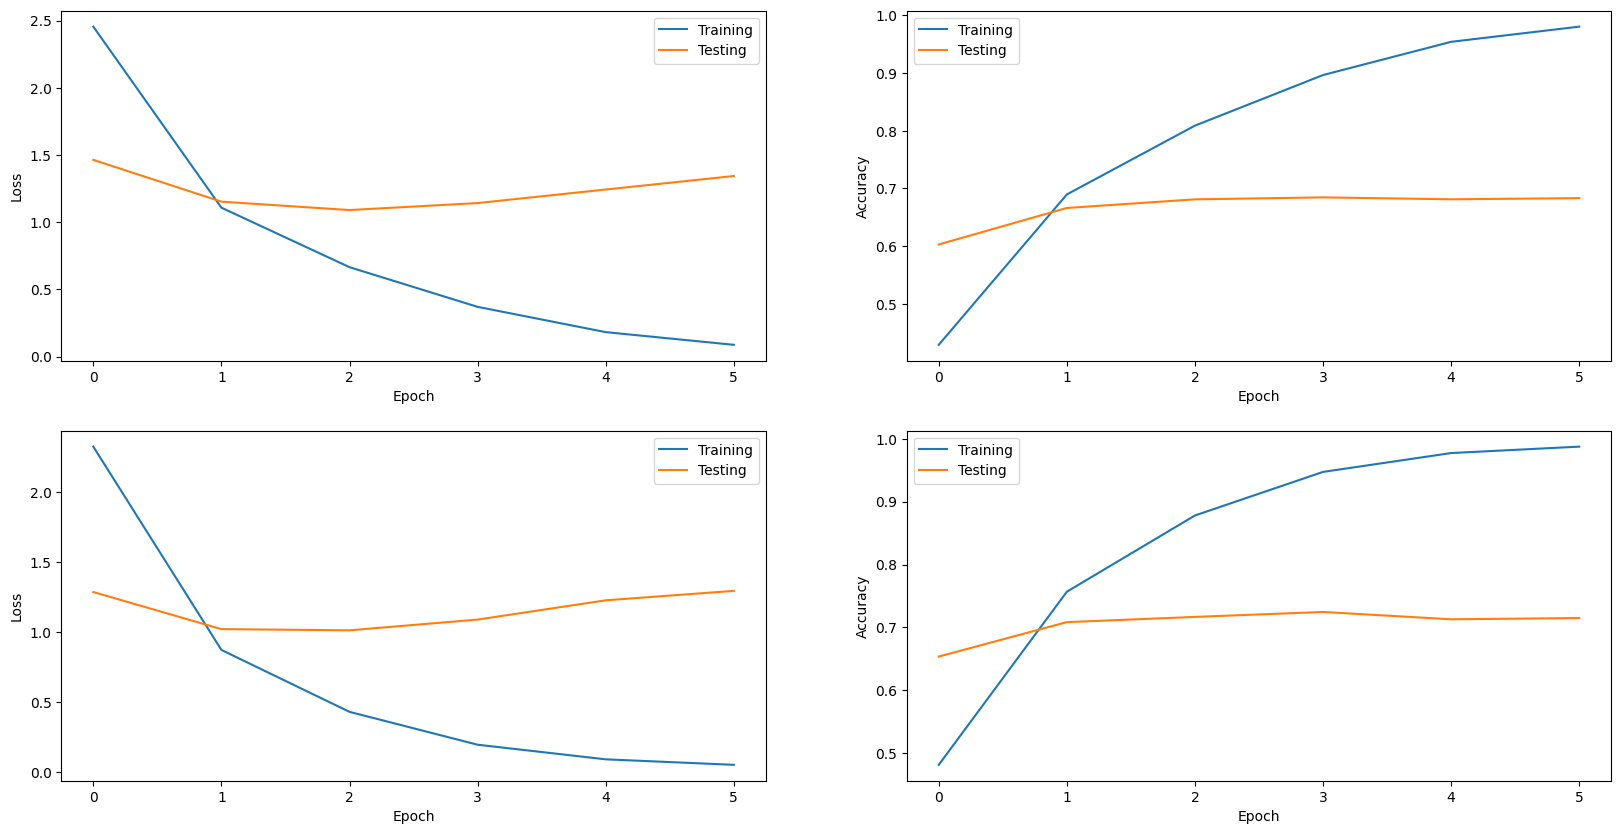

In [ ]:
lossAccPlot(WDDict, modelnames_wd)

In [ ]:
# Get last and max test accuracy
printTestAcc(noWDDict, modelnames)

print('-'*50)

printTestAcc(WDDict, modelnames_wd)

ConvNeXt Tiny -> Last Test Accuracy: 0.685 | Max Test Accuracy: 0.688 (Epoch:3)
ConvNeXt Base -> Last Test Accuracy: 0.6942 | Max Test Accuracy: 0.6971 (Epoch:11)
--------------------------------------------------
ConvNeXt TinyWD -> Last Test Accuracy: 0.6833 | Max Test Accuracy: 0.6846 (Epoch:3)
ConvNeXt BaseWD -> Last Test Accuracy: 0.7148 | Max Test Accuracy: 0.7245 (Epoch:3)


From the result above, applying weight decay to the optimizer improved the performance by 1%. We will come back to visit the preferrable weight decay value and learning rate after we try augmenting the data.

We will stick with using learning rate at 5e-5 and weight decay at 1e-8, which is from the fine-tuning setting section of ConvNeXt's paper.

In [27]:
def save_model(models, modelnames, epochDict, path='models/'):
    for model, modelname in zip(models, modelnames):
        torch.save(model.state_dict(), f'{path}/ConvNeXt_{modelname}.pt')
        # Save the loss and accuracy for train and test set
        temp = dict()
        temp[f'Training Loss_{modelname}'] = epochDict[f'Training Loss_{modelname}']
        temp[f'Training Accuracy_{modelname}'] = epochDict[f'Training Accuracy_{modelname}']
        temp[f'Test Loss_{modelname}'] = epochDict[f'Test Loss_{modelname}']
        temp[f'Test Accuracy_{modelname}'] = epochDict[f'Test Accuracy_{modelname}']
        with open(f'{path}/ConvNeXt_{modelname}_EpochDict.json', 'w') as fp:
            json.dump(temp, fp)

In [ ]:
save_model(models_wd, modelnames_wd, WDDict)

del models, models_wd, modelnames, modelnames_wd, noWDDict, WDDict, convnext_tiny, convnext_tiny_wd, convnext_base, convnext_base_wd
del criterion, optimizer, optimizer_wd, lr_scheduler
torch.cuda.empty_cache()

## **Data Augmentation**

In [28]:
train_data = np.stack((train_data_R, train_data_G, train_data_B), axis=3)
test_data = np.stack((test_data_R, test_data_G, test_data_B), axis=3)

print(train_data.shape, test_data.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [29]:
X_train, y_train = train_data, train_fine_labels
X_test, y_test = test_data, test_fine_labels

print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [30]:
#Transform data to Tensor
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std), # using the mean and standard deviation calculated above
    transforms.RandomErasing()
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

In [31]:
# Apply the augmentation
augmented_train_data = []
augmented_train_label = []
for image, label in zip(X_train, y_train_encoded):
    # image = image.reshape(32, 32, 3)
    image = Image.fromarray(image)
    augmented_train_data.append(train_transform(image))
    augmented_train_label.append(label)

augmented_test_data = []
augmented_test_label = []
for image, label in zip(X_test, y_test_encoded):
    # image = image.reshape(32, 32, 3)
    image = Image.fromarray(image)
    augmented_test_data.append(test_transform(image))
    augmented_test_label.append(label)

augmented_train_data = torch.stack(augmented_train_data)
augmented_test_data = torch.stack(augmented_test_data)

print(f'Augmented Train Data Shape: {augmented_train_data.shape}\nAugmented Test Data Shape: {augmented_test_data.shape}')

Augmented Train Data Shape: torch.Size([50000, 3, 32, 32])
Augmented Test Data Shape: torch.Size([10000, 3, 32, 32])


In [32]:
# Create the dataset
aug_train_dataset = TensorDataset(augmented_train_data, torch.Tensor(augmented_train_label))
aug_test_dataset = TensorDataset(augmented_test_data, torch.Tensor(augmented_test_label))

# Create the dataloader
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=32, shuffle=False)

In [41]:
convnext_tiny = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)


convnext_tiny.to(device)
convnext_base.to(device)

models = [convnext_tiny, convnext_base]
modelnames = ['Tiny', 'Base']

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this 

In [42]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW([{'params': model.parameters()} for model in models], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [43]:
# Train the model
augmentDataModel = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

ConvNeXt Tiny -> Epoch: 1/30 
            Train Loss: 2.7571682888031006 | Train Accuracy: 0.35554 
            Test Loss: 1.6260753303527833 | Test Accuracy: 0.5601
ConvNeXt Tiny -> Epoch: 2/30 
            Train Loss: 1.406966480293274 | Train Accuracy: 0.61218 
            Test Loss: 1.27042015209198 | Test Accuracy: 0.633
ConvNeXt Tiny -> Epoch: 3/30 
            Train Loss: 0.9142804096603394 | Train Accuracy: 0.7406 
            Test Loss: 1.1563044081687928 | Test Accuracy: 0.662
ConvNeXt Tiny -> Epoch: 4/30 
            Train Loss: 0.5632344714331627 | Train Accuracy: 0.84452 
            Test Loss: 1.1714729768753052 | Test Accuracy: 0.6644
EarlyStopping counter: 1 out of 3
ConvNeXt Tiny -> Epoch: 5/30 
            Train Loss: 0.31746045439720155 | Train Accuracy: 0.92004 
            Test Loss: 1.225752236175537 | Test Accuracy: 0.6669
EarlyStopping counter: 2 out of 3
ConvNeXt Tiny -> Epoch: 6/30 
            Train Loss: 0.16479241602897643 | Train Accuracy: 0.9662 
        

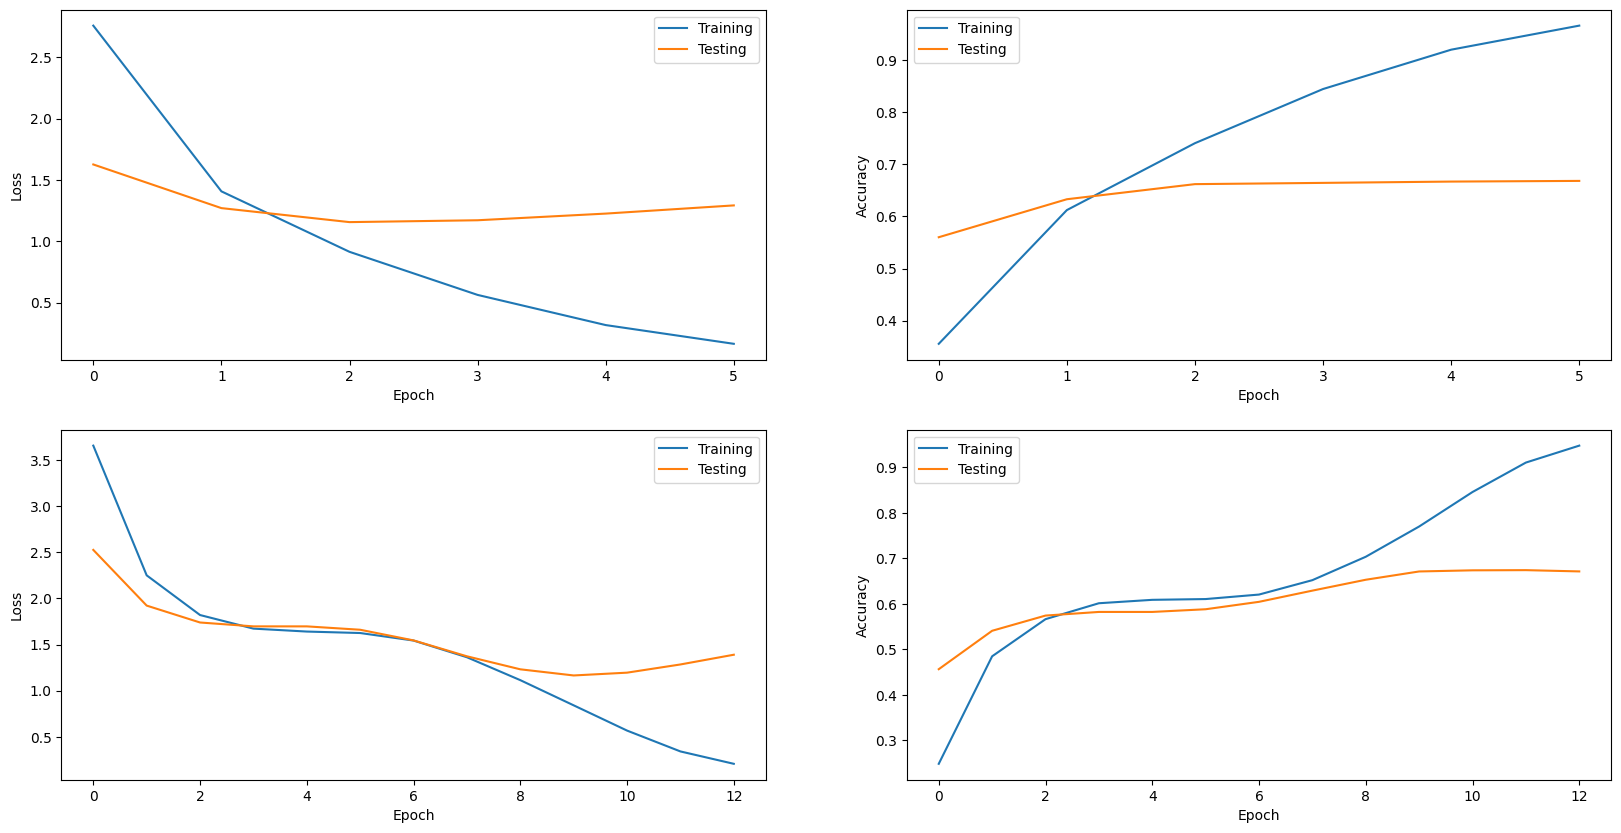

In [44]:
lossAccPlot(augmentDataModel, modelnames)

In [45]:
# Get last and max test accuracy
printTestAcc(augmentDataModel, modelnames)

ConvNeXt Tiny -> Last Test Accuracy: 0.6682 | Max Test Accuracy: 0.6682 (Epoch:5)
ConvNeXt Base -> Last Test Accuracy: 0.6712 | Max Test Accuracy: 0.674 (Epoch:11)


In [46]:
del models, modelnames, augmentDataModel, convnext_tiny, convnext_base
del criterion, optimizer, lr_scheduler
torch.cuda.empty_cache()

Using data augmentation seems to not help with model overfitting and made the performance worse. However, we will try to use augmented data **after** training the model on normal data.

In [33]:
def concatenateDict(*dicts):
    result = {}
    for dictionary in dicts:
        for key, value in dictionary.items():
            if key in result:
                result[key] += value
            else:
                result[key] = value.copy()
    return result

In [48]:
convnext_tiny = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                                    num_labels=len(label_fine),
                                                                    label2id=label2id,
                                                                    id2label=id2label,
                                                                    ignore_mismatched_sizes=True)

convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                    num_labels=len(label_fine),
                                                                    label2id=label2id,
                                                                    id2label=id2label,
                                                                    ignore_mismatched_sizes=True)

state_tiny = torch.load('models/ConvNeXt_TinyWD.pt')
state_base = torch.load('models/ConvNeXt_BaseWD.pt')

with open('models/ConvNeXt_TinyWD_EpochDict.json') as fp:
    epochDict_tiny = json.load(fp)
with open('models/ConvNeXt_BaseWD_EpochDict.json') as fp:
    epochDict_base = json.load(fp)
epochDict = concatenateDict(epochDict_tiny, epochDict_base)

convnext_tiny.load_state_dict(state_tiny)
convnext_base.load_state_dict(state_base)

convnext_tiny.to(device)
convnext_base.to(device)

models = [convnext_tiny, convnext_base]
modelnames = ['Tiny', 'Base']

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this 

In [49]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW([{'params': model.parameters()} for model in models], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [50]:
# Train the model
augmentData_trainedModel = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

ConvNeXt Tiny -> Epoch: 1/30 
            Train Loss: 1.165462861251831 | Train Accuracy: 0.6842 
            Test Loss: 1.062752544403076 | Test Accuracy: 0.7017
ConvNeXt Tiny -> Epoch: 2/30 
            Train Loss: 0.6255727142333984 | Train Accuracy: 0.8257 
            Test Loss: 1.1087303442955017 | Test Accuracy: 0.7047
EarlyStopping counter: 1 out of 3
ConvNeXt Tiny -> Epoch: 3/30 
            Train Loss: 0.2818457741379738 | Train Accuracy: 0.92888 
            Test Loss: 1.191332255935669 | Test Accuracy: 0.7057
EarlyStopping counter: 2 out of 3
ConvNeXt Tiny -> Epoch: 4/30 
            Train Loss: 0.11281569571435451 | Train Accuracy: 0.97668 
            Test Loss: 1.3001208245277405 | Test Accuracy: 0.7017
EarlyStopping counter: 3 out of 3
Early stopping at epoch 4
ConvNeXt Base -> Epoch: 1/30 
            Train Loss: 1.0012035109996795 | Train Accuracy: 0.73686 
            Test Loss: 0.9547897873878479 | Test Accuracy: 0.737
ConvNeXt Base -> Epoch: 2/30 
            Train

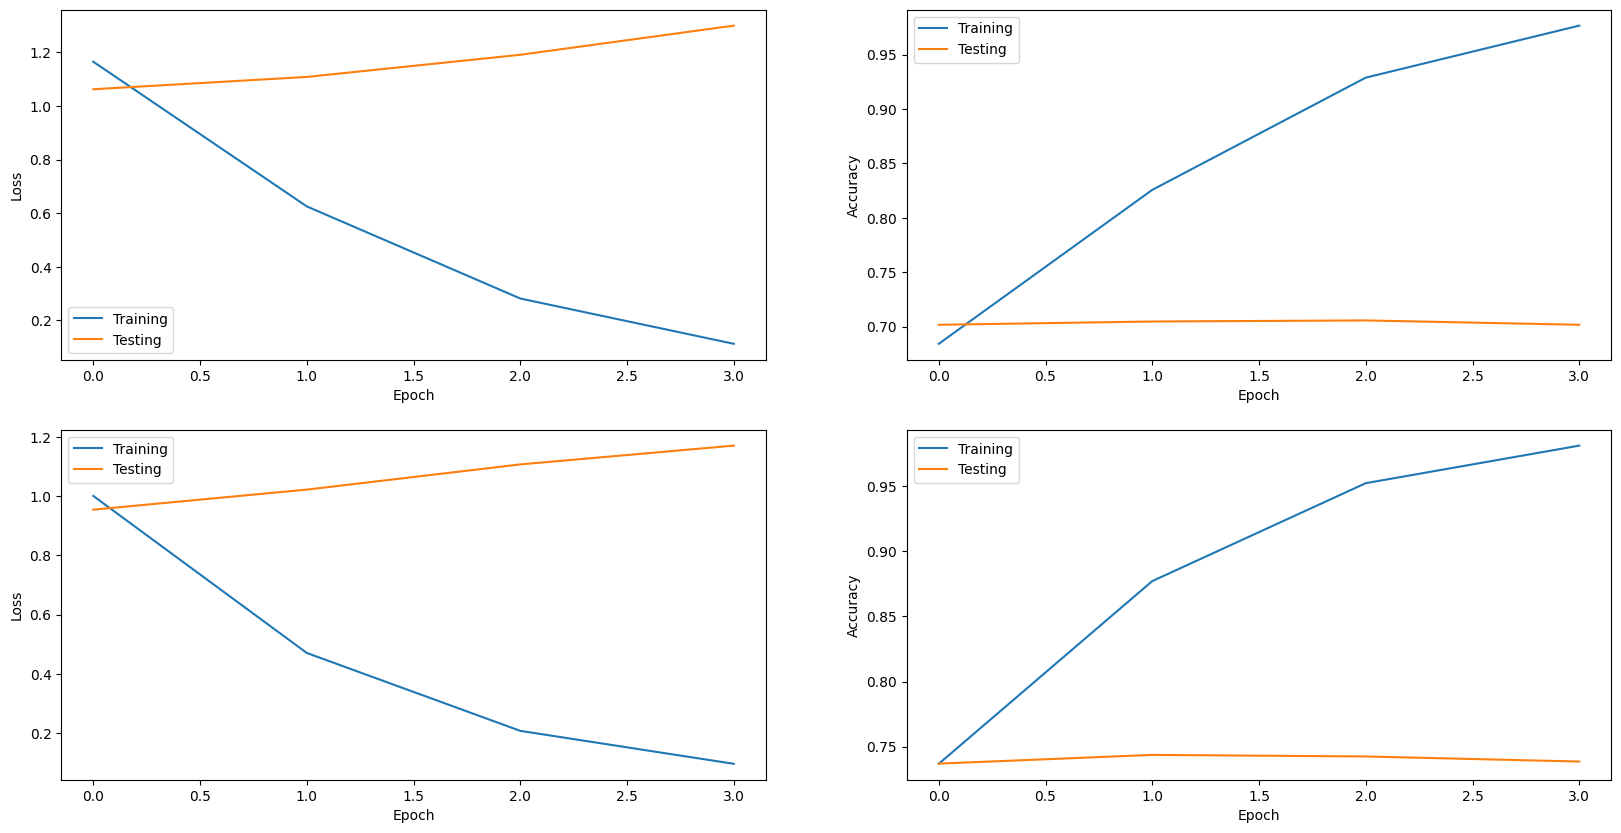

In [51]:
epochDict_combined = concatenateDict(epochDict, augmentData_trainedModel)
lossAccPlot(epochDict_combined, modelnames)

In [52]:
printTestAcc(epochDict_combined, modelnames)

ConvNeXt Tiny -> Last Test Accuracy: 0.7017 | Max Test Accuracy: 0.7057 (Epoch:2)
ConvNeXt Base -> Last Test Accuracy: 0.7386 | Max Test Accuracy: 0.7437 (Epoch:1)


In [58]:
del models, modelnames, augmentData_trainedModel, convnext_tiny, convnext_base
del criterion, optimizer, lr_scheduler
torch.cuda.empty_cache()

From this we can see that training on data augmentation after training on actual data does help increase the performance by quite a lot. Therefore, we will continue using this method.

Next up, we will try other scheduler methods.

## **Scheduler**

Right now, we are using CosineAnnealingLR as our scheduler. We will now try to use other schedulers.

- No Scheduler
- Linear Decay (Commonly used)
- Exponential Decay

NOTE: To save up some times we will train on ConvNeXt Base model only.

In [34]:
base_noscheduler = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                    num_labels=len(label_fine),
                                                                    label2id=label2id,
                                                                    id2label=id2label,
                                                                    ignore_mismatched_sizes=True)

base_noscheduler.to(device)

models_nosched = [base_noscheduler]
modelnames_nosched = ['BaseNoScheduler']

# Loss function
criterion_nosched = nn.CrossEntropyLoss()

# Optimizer
optimizer_nosched = torch.optim.AdamW([{'params': model.parameters()} for model in models_nosched], lr=5e-5, weight_decay=1e-8)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
nosched_datadict_noaug = train_model(models_nosched, modelnames_nosched, criterion_nosched, optimizer_nosched, scheduler=None, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt BaseNoScheduler -> Epoch: 1/30 
            Train Loss: 2.3107168628692625 | Train Accuracy: 0.48928 
            Test Loss: 1.2786488925933839 | Test Accuracy: 0.6543
ConvNeXt BaseNoScheduler -> Epoch: 2/30 
            Train Loss: 0.8643747987699508 | Train Accuracy: 0.7589 
            Test Loss: 1.0011759351730347 | Test Accuracy: 0.7159
ConvNeXt BaseNoScheduler -> Epoch: 3/30 
            Train Loss: 0.42632009326457976 | Train Accuracy: 0.87688 
            Test Loss: 1.0276963232040406 | Test Accuracy: 0.7176
EarlyStopping counter: 1 out of 3
ConvNeXt BaseNoScheduler -> Epoch: 4/30 
            Train Loss: 0.19381876893162728 | Train Accuracy: 0.94822 
            Test Loss: 1.0775654751777648 | Test Accuracy: 0.723
EarlyStopping counter: 2 out of 3
ConvNeXt BaseNoScheduler -> Epoch: 5/30 
            Train Loss: 0.0948876135534048 | Train Accuracy: 0.97598 
            Test Loss: 1.1830649735450744 | Test Accuracy: 0.723
EarlyStopping counter: 3 out of 3
Early stopping

In [36]:
nosched_datadict_aug = train_model(models_nosched, modelnames_nosched, criterion_nosched, optimizer_nosched, scheduler=None, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

ConvNeXt BaseNoScheduler -> Epoch: 1/30 
            Train Loss: 0.9521692558479309 | Train Accuracy: 0.73794 
            Test Loss: 0.9108878874778747 | Test Accuracy: 0.7411
ConvNeXt BaseNoScheduler -> Epoch: 2/30 
            Train Loss: 0.3394731359362602 | Train Accuracy: 0.90844 
            Test Loss: 1.0175729146957397 | Test Accuracy: 0.74
EarlyStopping counter: 1 out of 3
ConvNeXt BaseNoScheduler -> Epoch: 3/30 
            Train Loss: 0.11894017836138607 | Train Accuracy: 0.97126 
            Test Loss: 1.144439983844757 | Test Accuracy: 0.7384
EarlyStopping counter: 2 out of 3
ConvNeXt BaseNoScheduler -> Epoch: 4/30 
            Train Loss: 0.059026345167458055 | Train Accuracy: 0.98498 
            Test Loss: 1.3009974859237672 | Test Accuracy: 0.7271
EarlyStopping counter: 3 out of 3
Early stopping at epoch 4


In [37]:
base_lineardecay = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                    num_labels=len(label_fine),
                                                                    label2id=label2id,
                                                                    id2label=id2label,
                                                                    ignore_mismatched_sizes=True)

base_lineardecay.to(device)

models_linear = [base_lineardecay]
modelnames_linear = ['BaseLinearDecay']

# Loss function
criterion_linear = nn.CrossEntropyLoss()

# Optimizer
optimizer_linear = torch.optim.AdamW([{'params': model.parameters()} for model in models_linear], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
linearLR_sched = torch.optim.lr_scheduler.LinearLR(optimizer_linear)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
lineardecay_datadict_noaug = train_model(models_linear, modelnames_linear, criterion_linear, optimizer_linear, linearLR_sched, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt BaseLinearDecay -> Epoch: 1/30 
            Train Loss: 3.4597696062469483 | Train Accuracy: 0.31468 
            Test Loss: 2.303872151184082 | Test Accuracy: 0.4963
ConvNeXt BaseLinearDecay -> Epoch: 2/30 
            Train Loss: 1.6448014156341553 | Train Accuracy: 0.60934 
            Test Loss: 1.3544200357437133 | Test Accuracy: 0.6388
ConvNeXt BaseLinearDecay -> Epoch: 3/30 
            Train Loss: 0.9434200979042053 | Train Accuracy: 0.74658 
            Test Loss: 1.0889481995582582 | Test Accuracy: 0.6933
ConvNeXt BaseLinearDecay -> Epoch: 4/30 
            Train Loss: 0.5607311941766739 | Train Accuracy: 0.84284 
            Test Loss: 1.0551496410369874 | Test Accuracy: 0.7077
ConvNeXt BaseLinearDecay -> Epoch: 5/30 
            Train Loss: 0.3071076467323303 | Train Accuracy: 0.91554 
            Test Loss: 1.132753544998169 | Test Accuracy: 0.7051
EarlyStopping counter: 1 out of 3
ConvNeXt BaseLinearDecay -> Epoch: 6/30 
            Train Loss: 0.1669948468470573

In [39]:
lineardecay_datadict_aug = train_model(models_linear, modelnames_linear, criterion_linear, optimizer_linear, linearLR_sched, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

ConvNeXt BaseLinearDecay -> Epoch: 1/30 
            Train Loss: 1.0319078663349153 | Train Accuracy: 0.7182 
            Test Loss: 0.9523228764533996 | Test Accuracy: 0.7315
ConvNeXt BaseLinearDecay -> Epoch: 2/30 
            Train Loss: 0.38109509654045104 | Train Accuracy: 0.89414 
            Test Loss: 1.081976175403595 | Test Accuracy: 0.7253
EarlyStopping counter: 1 out of 3
ConvNeXt BaseLinearDecay -> Epoch: 3/30 
            Train Loss: 0.13693932827055455 | Train Accuracy: 0.96544 
            Test Loss: 1.2183069562911988 | Test Accuracy: 0.7285
EarlyStopping counter: 2 out of 3
ConvNeXt BaseLinearDecay -> Epoch: 4/30 
            Train Loss: 0.0612337186793983 | Train Accuracy: 0.9855 
            Test Loss: 1.3599690377235412 | Test Accuracy: 0.7228
EarlyStopping counter: 3 out of 3
Early stopping at epoch 4


In [40]:
base_expodecay = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                    num_labels=len(label_fine),
                                                                    label2id=label2id,
                                                                    id2label=id2label,
                                                                    ignore_mismatched_sizes=True)

base_expodecay.to(device)

models_expo = [base_expodecay]
modelnames_expo = ['BaseExpDecay']

# Loss function
criterion_expo = nn.CrossEntropyLoss()

# Optimizer
optimizer_expo = torch.optim.AdamW([{'params': model.parameters()} for model in models_expo], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
expoLR = torch.optim.lr_scheduler.ExponentialLR(optimizer_expo, gamma=0.9)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
expodecay_datadict_noaug = train_model(models_expo, modelnames_expo, criterion_expo, optimizer_expo, expoLR, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt BaseExpDecay -> Epoch: 1/30 
            Train Loss: 2.2710158880233764 | Train Accuracy: 0.49362 
            Test Loss: 1.2522117380142213 | Test Accuracy: 0.6589
ConvNeXt BaseExpDecay -> Epoch: 2/30 
            Train Loss: 0.8521437025356293 | Train Accuracy: 0.75982 
            Test Loss: 1.0000447230339051 | Test Accuracy: 0.7123
ConvNeXt BaseExpDecay -> Epoch: 3/30 
            Train Loss: 0.42078098835945127 | Train Accuracy: 0.88156 
            Test Loss: 0.9850947174549103 | Test Accuracy: 0.7272
ConvNeXt BaseExpDecay -> Epoch: 4/30 
            Train Loss: 0.19410403252363204 | Train Accuracy: 0.95044 
            Test Loss: 1.0700916714668274 | Test Accuracy: 0.7228
EarlyStopping counter: 1 out of 3
ConvNeXt BaseExpDecay -> Epoch: 5/30 
            Train Loss: 0.08589105287373065 | Train Accuracy: 0.9813 
            Test Loss: 1.1604090255737305 | Test Accuracy: 0.7245
EarlyStopping counter: 2 out of 3
ConvNeXt BaseExpDecay -> Epoch: 6/30 
            Train Loss

In [42]:
expodecay_datadict_aug = train_model(models_expo, modelnames_expo, criterion_expo, optimizer_expo, expoLR, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

ConvNeXt BaseExpDecay -> Epoch: 1/30 
            Train Loss: 0.9637566295337677 | Train Accuracy: 0.73678 
            Test Loss: 0.9307277698516846 | Test Accuracy: 0.7411
ConvNeXt BaseExpDecay -> Epoch: 2/30 
            Train Loss: 0.41484233491659167 | Train Accuracy: 0.88834 
            Test Loss: 1.0139572905540466 | Test Accuracy: 0.742
EarlyStopping counter: 1 out of 3
ConvNeXt BaseExpDecay -> Epoch: 3/30 
            Train Loss: 0.18188277372181416 | Train Accuracy: 0.95748 
            Test Loss: 1.1133520467758178 | Test Accuracy: 0.735
EarlyStopping counter: 2 out of 3
ConvNeXt BaseExpDecay -> Epoch: 4/30 
            Train Loss: 0.07728707468658685 | Train Accuracy: 0.98558 
            Test Loss: 1.2086431770801545 | Test Accuracy: 0.7364
EarlyStopping counter: 3 out of 3
Early stopping at epoch 4


In [43]:
printTestAcc(nosched_datadict_noaug, modelnames_nosched)
printTestAcc(lineardecay_datadict_noaug, modelnames_linear)
printTestAcc(expodecay_datadict_noaug, modelnames_expo)

ConvNeXt BaseNoScheduler -> Last Test Accuracy: 0.723 | Max Test Accuracy: 0.723 (Epoch:3)
ConvNeXt BaseLinearDecay -> Last Test Accuracy: 0.7038 | Max Test Accuracy: 0.7077 (Epoch:3)
ConvNeXt BaseExpDecay -> Last Test Accuracy: 0.7184 | Max Test Accuracy: 0.7272 (Epoch:2)


In [44]:
# Merge data into one dictionary
nosched_datadict = concatenateDict(nosched_datadict_noaug, nosched_datadict_aug)
lineardecay_datadict = concatenateDict(lineardecay_datadict_noaug, lineardecay_datadict_aug)
expodecay_datadict = concatenateDict(expodecay_datadict_noaug, expodecay_datadict_aug)

In [45]:
printTestAcc(nosched_datadict, modelnames_nosched)
printTestAcc(lineardecay_datadict, modelnames_linear)
printTestAcc(expodecay_datadict, modelnames_expo)

ConvNeXt BaseNoScheduler -> Last Test Accuracy: 0.7271 | Max Test Accuracy: 0.7411 (Epoch:5)
ConvNeXt BaseLinearDecay -> Last Test Accuracy: 0.7228 | Max Test Accuracy: 0.7315 (Epoch:7)
ConvNeXt BaseExpDecay -> Last Test Accuracy: 0.7364 | Max Test Accuracy: 0.742 (Epoch:7)


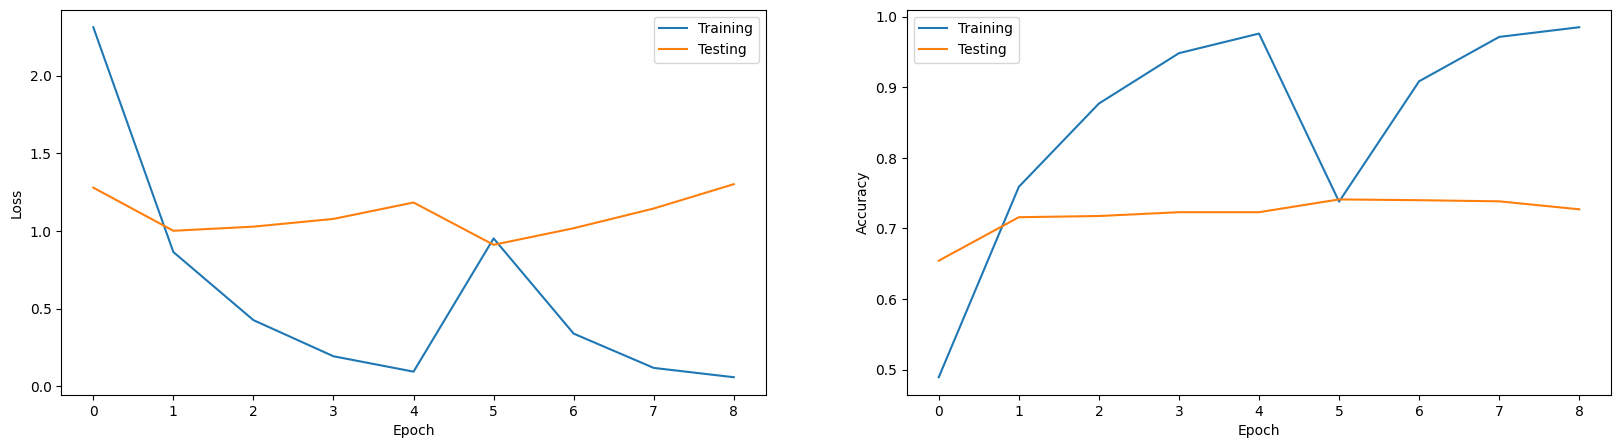

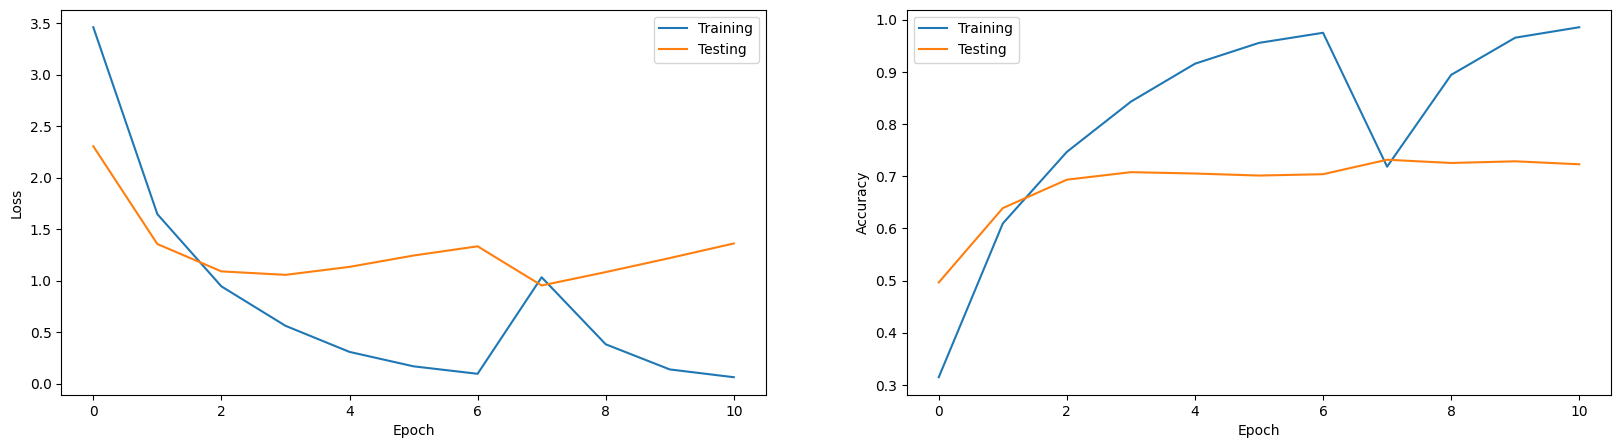

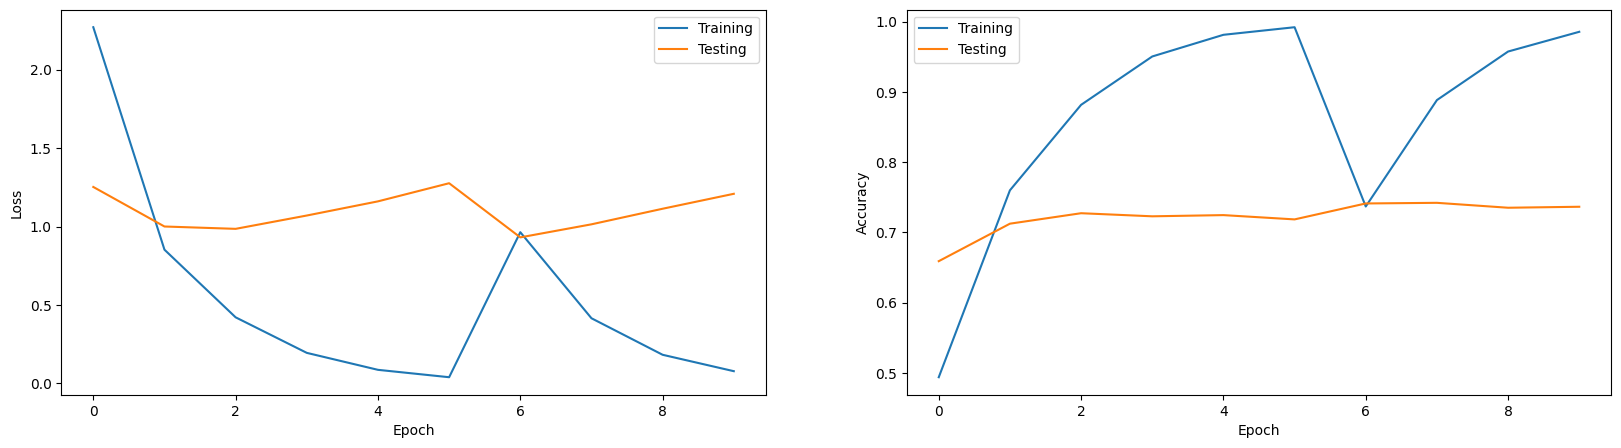

In [46]:
lossAccPlot(nosched_datadict, modelnames_nosched)
lossAccPlot(lineardecay_datadict, modelnames_linear)
lossAccPlot(expodecay_datadict, modelnames_expo)

Exponential Decay seems to be a tiny bit better than Cosine Annealing. We will continue using Exponential Decay and move on to find a better optimizer for ConvNeXt.

In [48]:
save_model(models_expo, modelnames_expo, expodecay_datadict)

del base_noscheduler, base_lineardecay, base_expodecay
del models_nosched, models_linear, models_expo
del modelnames_nosched, modelnames_linear, modelnames_expo
del criterion_nosched, criterion_linear, criterion_expo
del optimizer_nosched, optimizer_linear, optimizer_expo
del linearLR_sched, expoLR
del nosched_datadict_noaug, nosched_datadict_aug, nosched_datadict
del lineardecay_datadict_noaug, lineardecay_datadict_aug, lineardecay_datadict
del expodecay_datadict_noaug, expodecay_datadict_aug, expodecay_datadict
torch.cuda.empty_cache()

## **Optimizer**

In [49]:
base_sgd = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                            num_labels=len(label_fine),
                                                            label2id=label2id,
                                                            id2label=id2label,
                                                            ignore_mismatched_sizes=True)

base_sgd.to(device)
models_sgd = [base_sgd]
modelnames_sgd = ['BaseSGD']

# Loss function
criterion_sgd = nn.CrossEntropyLoss()

# Optimizer
optimizer_sgd = torch.optim.SGD([{'params': model.parameters()} for model in models_sgd], lr=5e-5, momentum=0.9, weight_decay=1e-8)

# Learning rate scheduler
sgdLR = torch.optim.lr_scheduler.ExponentialLR(optimizer_sgd, gamma=0.9)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
sgd_datadict_noaug = train_model(models_sgd, modelnames_sgd, criterion_sgd, optimizer_sgd, sgdLR, num_epochs=300, train_loader=train_loader, test_loader=test_loader, patience=10)

ConvNeXt BaseSGD -> Epoch: 1/300 
            Train Loss: 4.560905074157715 | Train Accuracy: 0.02442 
            Test Loss: 4.503596139526367 | Test Accuracy: 0.0482
ConvNeXt BaseSGD -> Epoch: 2/300 
            Train Loss: 4.444360678710938 | Train Accuracy: 0.08968 
            Test Loss: 4.384954054260254 | Test Accuracy: 0.1305
ConvNeXt BaseSGD -> Epoch: 3/300 
            Train Loss: 4.3222518975830075 | Train Accuracy: 0.17362 
            Test Loss: 4.261586447906494 | Test Accuracy: 0.209
ConvNeXt BaseSGD -> Epoch: 4/300 
            Train Loss: 4.1973921347045895 | Train Accuracy: 0.23422 
            Test Loss: 4.137509621429444 | Test Accuracy: 0.2515
ConvNeXt BaseSGD -> Epoch: 5/300 
            Train Loss: 4.074490422058106 | Train Accuracy: 0.27104 
            Test Loss: 4.018517594146728 | Test Accuracy: 0.2796
ConvNeXt BaseSGD -> Epoch: 6/300 
            Train Loss: 3.9576939865112304 | Train Accuracy: 0.29312 
            Test Loss: 3.905975631713867 | Test Accurac

In [52]:
sgd_datadict_aug = train_model(models_sgd, modelnames_sgd, criterion_sgd, optimizer_sgd, sgdLR, num_epochs=300, train_loader=aug_train_loader, test_loader=aug_test_loader, patience=10)

ConvNeXt BaseSGD -> Epoch: 1/300 
            Train Loss: 3.191488451080322 | Train Accuracy: 0.33714 
            Test Loss: 2.9188030700683596 | Test Accuracy: 0.4047
ConvNeXt BaseSGD -> Epoch: 2/300 
            Train Loss: 3.191488439025879 | Train Accuracy: 0.33714 
            Test Loss: 2.91880306930542 | Test Accuracy: 0.4047
ConvNeXt BaseSGD -> Epoch: 3/300 
            Train Loss: 3.1914884326171875 | Train Accuracy: 0.33714 
            Test Loss: 2.918803091430664 | Test Accuracy: 0.4047
EarlyStopping counter: 1 out of 10
ConvNeXt BaseSGD -> Epoch: 4/300 
            Train Loss: 3.191488449020386 | Train Accuracy: 0.33714 
            Test Loss: 2.9188030784606935 | Test Accuracy: 0.4047
EarlyStopping counter: 2 out of 10
ConvNeXt BaseSGD -> Epoch: 5/300 
            Train Loss: 3.191488445892334 | Train Accuracy: 0.33714 
            Test Loss: 2.9188030868530275 | Test Accuracy: 0.4047
EarlyStopping counter: 3 out of 10
ConvNeXt BaseSGD -> Epoch: 6/300 
            Train 

In [53]:
base_adam = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                            num_labels=len(label_fine),
                                                            label2id=label2id,
                                                            id2label=id2label,
                                                            ignore_mismatched_sizes=True)

base_adam.to(device)
models_adam = [base_adam]
modelnames_adam = ['BaseAdam']

# Loss function
criterion_adam = nn.CrossEntropyLoss()

# Optimizer
optimizer_adam = torch.optim.Adam([{'params': model.parameters()} for model in models_adam], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
adamLR = torch.optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.9)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
adam_datadict_noaug = train_model(models_adam, modelnames_adam, criterion_adam, optimizer_adam, adamLR, num_epochs=300, train_loader=train_loader, test_loader=test_loader, patience=5)

ConvNeXt BaseAdam -> Epoch: 1/300 
            Train Loss: 2.3185476403427123 | Train Accuracy: 0.48548 
            Test Loss: 1.2756835458755493 | Test Accuracy: 0.6536
ConvNeXt BaseAdam -> Epoch: 2/300 
            Train Loss: 0.8587229479026794 | Train Accuracy: 0.76028 
            Test Loss: 1.011246167755127 | Test Accuracy: 0.7122
ConvNeXt BaseAdam -> Epoch: 3/300 
            Train Loss: 0.4246298906040192 | Train Accuracy: 0.88088 
            Test Loss: 1.0033547323703766 | Test Accuracy: 0.7212
ConvNeXt BaseAdam -> Epoch: 4/300 
            Train Loss: 0.19255672944784163 | Train Accuracy: 0.95138 
            Test Loss: 1.070608923149109 | Test Accuracy: 0.7232
EarlyStopping counter: 1 out of 5
ConvNeXt BaseAdam -> Epoch: 5/300 
            Train Loss: 0.08369491125613451 | Train Accuracy: 0.98188 
            Test Loss: 1.1703382950782777 | Test Accuracy: 0.7207
EarlyStopping counter: 2 out of 5
ConvNeXt BaseAdam -> Epoch: 6/300 
            Train Loss: 0.0389448239752650

In [55]:
adam_datadict_aug = train_model(models_adam, modelnames_adam, criterion_adam, optimizer_adam, adamLR, num_epochs=300, train_loader=aug_train_loader, test_loader=aug_test_loader, patience=5)

ConvNeXt BaseAdam -> Epoch: 1/300 
            Train Loss: 0.9825437690258026 | Train Accuracy: 0.73502 
            Test Loss: 0.9366508937835694 | Test Accuracy: 0.7403
ConvNeXt BaseAdam -> Epoch: 2/300 
            Train Loss: 0.4479301574373245 | Train Accuracy: 0.8803 
            Test Loss: 1.0311043815612793 | Test Accuracy: 0.7415
EarlyStopping counter: 1 out of 5
ConvNeXt BaseAdam -> Epoch: 3/300 
            Train Loss: 0.2096894041246176 | Train Accuracy: 0.95182 
            Test Loss: 1.150452484035492 | Test Accuracy: 0.7364
EarlyStopping counter: 2 out of 5
ConvNeXt BaseAdam -> Epoch: 4/300 
            Train Loss: 0.09386684095203876 | Train Accuracy: 0.98102 
            Test Loss: 1.2380557544708253 | Test Accuracy: 0.7374
EarlyStopping counter: 3 out of 5
ConvNeXt BaseAdam -> Epoch: 5/300 
            Train Loss: 0.0412025699532032 | Train Accuracy: 0.99322 
            Test Loss: 1.3147198289871216 | Test Accuracy: 0.7347
EarlyStopping counter: 4 out of 5
ConvNeXt B

In [56]:
print('Before Training on Augmentation')
print('='*20)
printTestAcc(sgd_datadict_noaug, modelnames_sgd)
printTestAcc(adam_datadict_noaug, modelnames_adam)

Before Training on Augmentation
ConvNeXt BaseSGD -> Last Test Accuracy: 0.4047 | Max Test Accuracy: 0.4047 (Epoch:63)
ConvNeXt BaseAdam -> Last Test Accuracy: 0.7256 | Max Test Accuracy: 0.7256 (Epoch:7)


In [57]:
sgd_datadict = concatenateDict(sgd_datadict_noaug, sgd_datadict_aug)
adam_datadict = concatenateDict(adam_datadict_noaug, adam_datadict_aug)
with open('models/ConvNeXt_BaseExpDecay_EpochDict.json', 'r') as fp:
    adamW_datadict = json.load(fp)

In [59]:
print('After Training on Augmentation')
print('='*20)
printTestAcc(sgd_datadict, modelnames_sgd)
printTestAcc(adam_datadict, modelnames_adam)
printTestAcc(adamW_datadict, ['BaseExpDecay'])

After Training on Augmentation
ConvNeXt BaseSGD -> Last Test Accuracy: 0.4047 | Max Test Accuracy: 0.4047 (Epoch:63)
ConvNeXt BaseAdam -> Last Test Accuracy: 0.7355 | Max Test Accuracy: 0.7415 (Epoch:9)
ConvNeXt BaseExpDecay -> Last Test Accuracy: 0.7364 | Max Test Accuracy: 0.742 (Epoch:7)


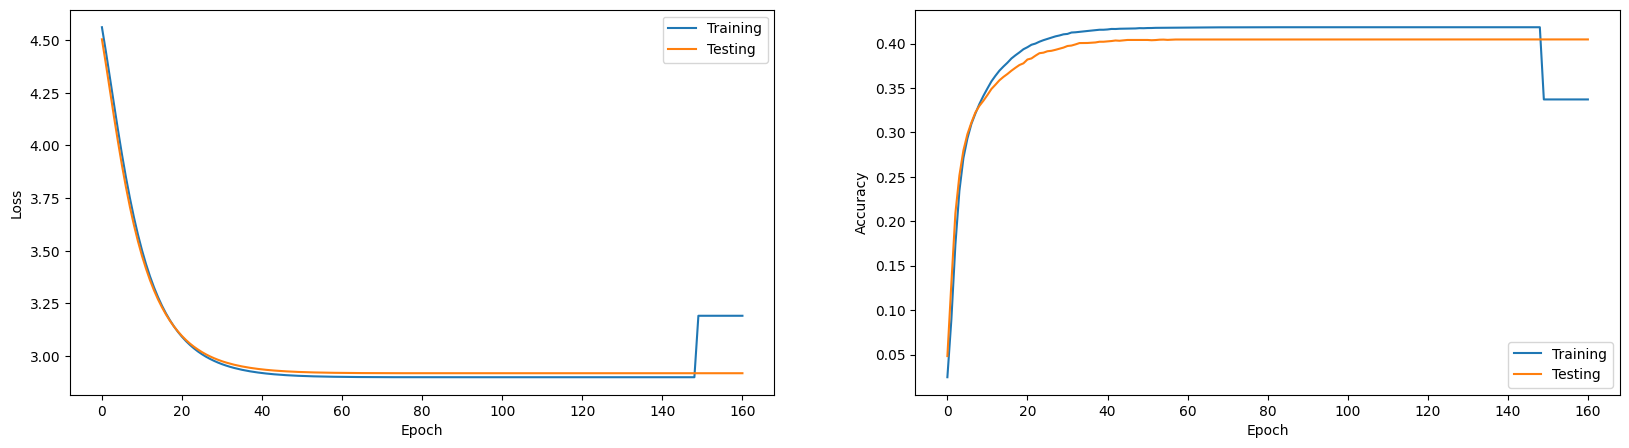

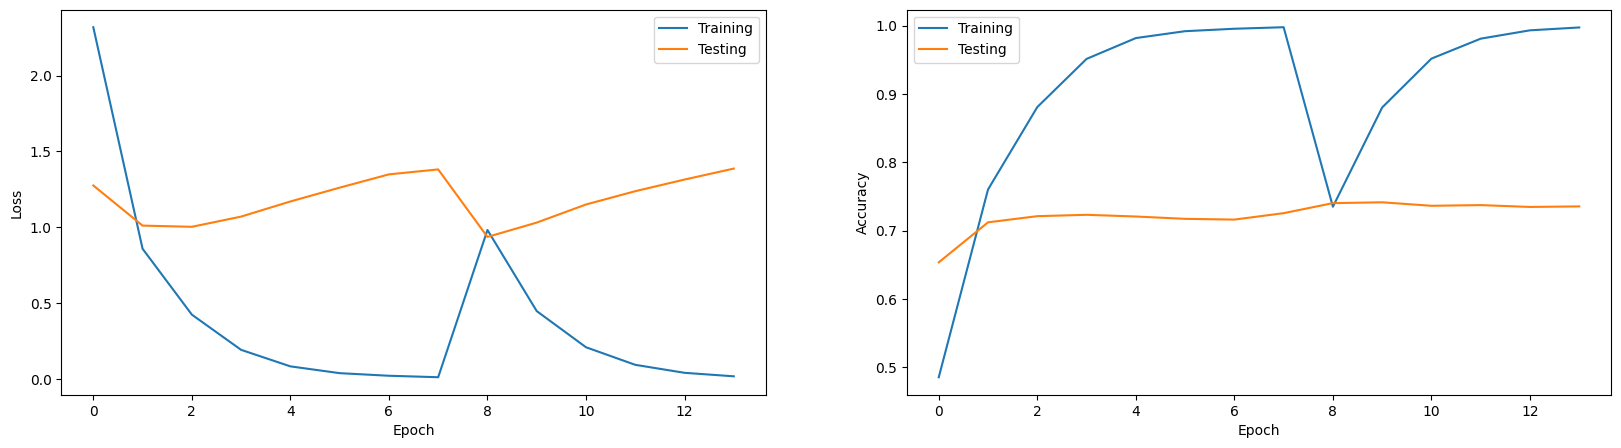

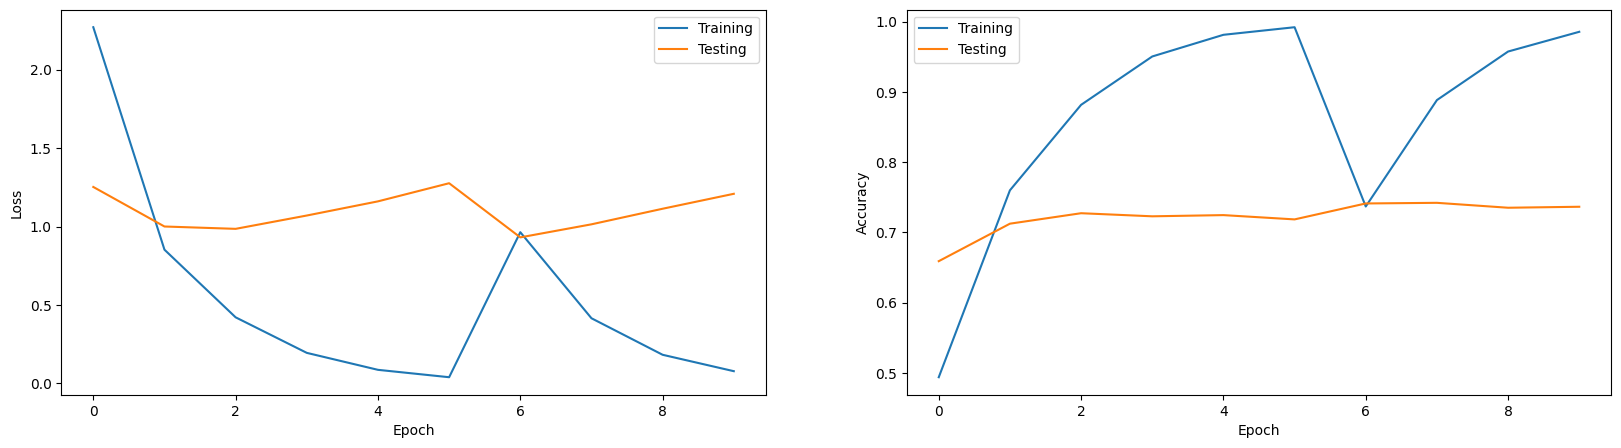

In [61]:
lossAccPlot(sgd_datadict, modelnames_sgd)
lossAccPlot(adam_datadict, modelnames_adam)
lossAccPlot(adamW_datadict, ['BaseExpDecay'])

From the result, we can see that SGD performs the worst, followed by Adam and AdamW with a small difference. Therefore, we will continue using AdamW.

Next, we will now tune the hyperparameters to find the most optimal parameters that will eventually improve our model's performance.

## **Hyperparameter Tuning**

In [ ]:
convnext_base_hyp = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                    num_labels=len(label_fine),
                                                                    label2id=label2id,
                                                                    id2label=id2label,
                                                                    ignore_mismatched_sizes=True)

convnext_base_hyp.to(device)
models_convnext_base_hyp = [convnext_base_hyp]
modelnames_convnext_base_hyp = ['ConvNeXt_Base_TuneHyperparameters']

# Loss function
criterion_convnext_base_hyp = nn.CrossEntropyLoss()

# Optimizer
optimizer_convnext_base_hyp = torch.optim.AdamW([{'params': model.parameters()} for model in models_convnext_base_hyp], lr=5e-5, weight_decay=1e-8)